<a href="https://colab.research.google.com/github/JaniVarga/Skin_detection/blob/main/Unet_skin_segmentation_with_cat_MCC_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
  !nvidia-smi -L
else:
  print(f"Number of core(s): {os.cpu_count()}")

GPU 0: Tesla T4 (UUID: GPU-9e06e9cf-0c01-a8c5-512c-cb1273f475d8)


In [4]:
class Unet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(0.1),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(0.1),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(0.1),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(0.1),
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(0.1)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      # nn.Dropout(0.1),
      nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      # nn.Dropout(0.1),
      nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      # nn.Dropout(0.1),
      nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      # nn.Dropout(0.1),
      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1, stride=1),
      # nn.Sigmoid()
  )

  def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
model = Unet(in_channels=3, out_channels=1)

In [6]:
try:
  import torchinfo

except:
  print("Install torchinfo...")
  !pip --quiet install torchinfo
  import torchinfo
  print("Torchinfo is installed and import.")

else:
  print("torchinfo is already installed.")

Install torchinfo...
Torchinfo is installed and import.


In [7]:
# Print with summary
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [1, 3, 224, 224]     [1, 1, 224, 224]     --                   True
├─Sequential (encoder)                   [1, 3, 224, 224]     [1, 1024, 7, 7]      --                   True
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    1,792                True
│    └─BatchNorm2d (1)                   [1, 64, 224, 224]    [1, 64, 224, 224]    128                  True
│    └─ReLU (2)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (3)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Dropout (4)                       [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   73,856               True
│    └─BatchNorm2d (

In [8]:
from pathlib import Path
import pathlib

In [9]:
zip_path = "/content/dataset.zip"

In [10]:
import zipfile

try:
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extractall(path="/content")
      print("Data is extracted.")

except FileNotFoundError:
    print("Data zip file is not found!")

Extracting zip file...
Data is extracted.


In [11]:
train_dir = Path("/content/dataset/train")
test_dir = Path("/content/dataset/val")

In [12]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [13]:
class CustomDataset(Dataset):
  def __init__(self, root_dir, image_transform=None, data_augmentation=None):
    super().__init__()
    self.root_dir = root_dir
    self.image_transform = image_transform
    self.data_augmentation = data_augmentation
    self.image_paths = sorted(list(glob.glob(f"{root_dir}/images/*.*")))
    self.masks_paths = sorted(list(glob.glob(f"{root_dir}/masks/*.*")))

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image= Image.open(self.image_paths[index])
    mask = Image.open(self.masks_paths[index])


    base_transforms = v2.Compose([
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(dtype=torch.float32, scale=True)])

    mask = base_transforms(mask)
    image = base_transforms(image)


    def common_augmentation(image, mask): # Concatenate image and mask to ensure consistent transformation
      combined = torch.cat([image, mask], dim=0)
      augmented_combined = self.data_augmentation(combined) # Split the rotated result back into image and mask
      image = augmented_combined[:3]
      mask = augmented_combined[3:]

      return image, mask

    if self.data_augmentation:
      image, mask = common_augmentation(image,mask)


    if self.image_transform:
      image = self.image_transform(image)

    return image, mask

In [14]:
image_transforms = v2.Compose([
    v2.ColorJitter(brightness=0.2,
                   contrast=0.2,
                   saturation=0.2,
                   hue=0.5),
    v2.GaussianNoise(mean=0, sigma=0.1)]
)

In [15]:
data_augmentations = v2.Compose([
    v2.RandomRotation(degrees=15),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ElasticTransform(alpha=1, sigma=50),
    ])

In [16]:
train_dataset = CustomDataset(root_dir=train_dir,
                            image_transform=image_transforms,
                            data_augmentation=data_augmentations)

In [17]:
val_dataset = CustomDataset(root_dir=test_dir,
                            image_transform=image_transforms,
                            data_augmentation=data_augmentations)

In [18]:
import numpy as np

def calculate_class_weights(dataset):
    class_counts = np.zeros((2,))  # Assuming binary classes 0 and 1
    for _, mask in dataset:
        class_counts += np.bincount(mask.flatten().numpy().astype(int), minlength=2)

    # Avoid division by zero
    class_weights = np.zeros_like(class_counts)
    non_zero_classes = class_counts != 0
    class_weights[non_zero_classes] = 1.0 / class_counts[non_zero_classes]

    sample_weights = []
    for _, mask in dataset:
        mask_class = mask.flatten().numpy().astype(int)
        sample_weight = class_weights[mask_class].mean()  # Average weight of the mask
        sample_weights.append(sample_weight)

    return np.array(sample_weights)

In [19]:
sample_weights = calculate_class_weights(train_dataset)

In [20]:
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [21]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=16,
                              shuffle=True,
                              # sampler=sampler,
                              # num_workers=os.cpu_count()
                              )

test_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=16,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(195, 50)

In [22]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0.01, verbose=False, model_name='checkpoint.pt', mode="min"):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.model_name = model_name
        self.mode = mode

    def __call__(self, val_loss, val_score, model):
        score = -val_loss if self.mode == 'min' else val_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'my_best_checkpoint_{self.model_name}.pth')
        self.val_loss_min = val_loss

In [23]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [24]:
def dice_coefficient(pred, target):
    smooth = 1e-6
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [25]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50) # T_max is the number of epochs

# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = DiceBCELoss()

early_stopping = EarlyStopping(patience=10, verbose=True, model_name="sematic_segmentation")

In [26]:
from tqdm.auto import tqdm

def training(epochs = 5,
             model = model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             optimizer=optimizer,
             loss_fn = loss_fn):

  model.to(device)
  train_losses = []
  test_losses = []
  dice_score = []


  for epoch in tqdm(range(epochs), leave=True, position=0):
    print(f"\n{'-'*45} \n Epoch: {epoch}")
    train_loss = 0
    test_loss = 0

    model.train()
    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    print(f"Batch: {batch} | Train Loss: {train_loss:.5f} ")

    model.eval()
    dice_scores = []
    with torch.inference_mode():
      for batch, (X, y) in enumerate(tqdm(test_dataloader)):
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        test_loss += loss.item()
        preds = (y_pred > 0.5).float()
        dice = dice_coefficient(preds, y)
        dice_scores.append(dice.item())


      test_loss /= len(test_dataloader)
      test_losses.append(test_loss)
      avg_dice_score = np.mean(dice_scores)
      dice_score.append(avg_dice_score)
      scheduler.step()
      # scheduler.step(test_loss)

      print(f"Learning rate: {scheduler.get_last_lr()[0]:.8f}")
      print(f"Batch: {batch} | Test Loss: {test_loss:.5f} | Avg Dice Score: {avg_dice_score:.4f}")


      early_stopping(test_loss, avg_dice_score, model)
      if early_stopping.early_stop:
        print("Early stopping triggered at epoch:", epoch)
        break


  return train_losses, test_losses, dice_score

In [27]:
test_train_losses, test_validation_losses, dice_score = training(epochs=1,
                             model=model,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn = loss_fn)

  0%|          | 0/1 [00:00<?, ?it/s]


--------------------------------------------- 
 Epoch: 0


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.96383 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00099901
Batch: 49 | Test Loss: 0.80712 | Avg Dice Score: 0.6500
Validation loss decreased (inf --> 0.807120).  Saving model ...


Text(0.5, 1.0, 'Loss')

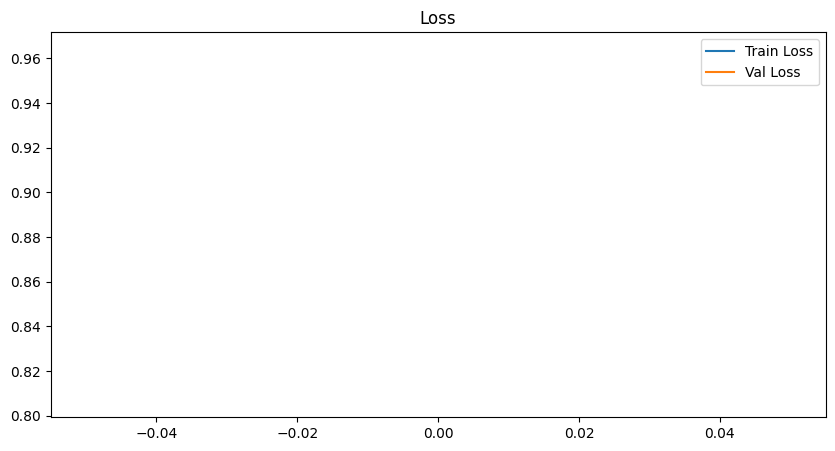

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.plot(test_train_losses, label="Train Loss")
ax.plot(test_validation_losses, label="Val Loss")
ax.legend()
ax.set_title("Loss")

In [29]:
def show_result(best_model_path, model):

  test_img_path = "/content/1728293261557.jpeg"
  test_img = Image.open(test_img_path)
  test_img = v2.ToImage()(test_img).to(device)
  base_transforms = v2.Compose([
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(dtype=torch.float32, scale=True)])
  # test_img = base_transforms(test_img) # Convert to float32
  # test_img = auto_transforms(test_img).unsqueeze(0).to(device)
  test_img = base_transforms(test_img).unsqueeze(0).to(device)


  model = model
  model.load_state_dict(torch.load(best_model_path, weights_only=True, map_location=device), strict=False)
  model.eval()

  with torch.inference_mode():
      y_logits = model(test_img)
      y_pred = torch.round(torch.sigmoid(y_logits))
      preds = F.interpolate(y_pred, size=(224, 224), mode='bilinear', align_corners=False)


  pred_mask = preds.to("cpu").squeeze()

  plt.imshow(pred_mask)
  plt.show()


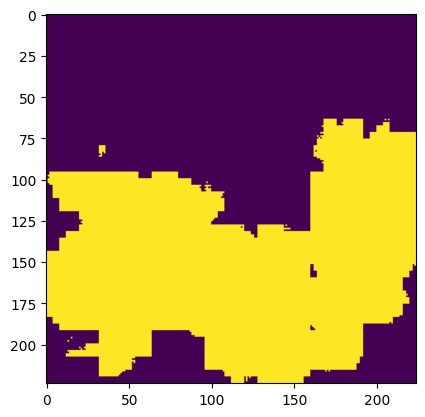

In [30]:
show_result(best_model_path="/content/my_best_checkpoint_sematic_segmentation.pth", model=model)

In [31]:
# class Unet_tuned(nn.Module):
#   def __init__(self, in_channels, out_channels):
#     super().__init__()

#     self.encoder1 = nn.Sequential( nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
#                                    nn.BatchNorm2d(64), nn.ReLU(inplace=True),
#                                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2, dilation=2),
#                                    nn.BatchNorm2d(64), nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=2),
#                                    nn.Dropout(0.1)
#                                    )
#     self.encoder2 = nn.Sequential( nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2),
#                                    nn.BatchNorm2d(128), nn.ReLU(inplace=True),
#                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2),
#                                    nn.BatchNorm2d(128),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=2),
#                                    nn.Dropout(0.1)
#                                    )
#     self.encoder3 = nn.Sequential( nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2),
#                                    nn.BatchNorm2d(256), nn.ReLU(inplace=True),
#                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2),
#                                    nn.BatchNorm2d(256),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=2),
#                                    nn.Dropout(0.1)
#                                    )
#     self.encoder4 = nn.Sequential( nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
#                                    nn.BatchNorm2d(512),
#                                    nn.ReLU(inplace=True),
#                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
#                                    nn.BatchNorm2d(512),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=2),
#                                    nn.Dropout(0.1)
#                                    )

#     self.bottleneck = nn.Sequential( nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=2, dilation=2),
#                                     nn.BatchNorm2d(1024),
#                                     nn.ReLU(inplace=True),
#                                     nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=2, dilation=2),
#                                     nn.BatchNorm2d(1024),
#                                     nn.ReLU(inplace=True),
#                                     nn.MaxPool2d(kernel_size=2),
#                                      nn.Dropout(0.1)
#                                      )

#     self.upconv1 = nn.Sequential( nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
#                                   nn.BatchNorm2d(512),
#                                   nn.ReLU(inplace=True),
#                                   nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
#                                   nn.BatchNorm2d(512),
#                                   nn.ReLU(inplace=True),
#                                   )
#     self.upconv2 = nn.Sequential( nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
#                                   nn.BatchNorm2d(256),
#                                   nn.ReLU(inplace=True),
#                                   nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2),
#                                   nn.BatchNorm2d(256),
#                                   nn.ReLU(inplace=True),
#                                   )
#     self.upconv3 = nn.Sequential( nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
#                                   nn.BatchNorm2d(128),
#                                   nn.ReLU(inplace=True),
#                                   nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2),
#                                   nn.BatchNorm2d(128),
#                                   nn.ReLU(inplace=True),
#                                   )
#     self.upconv4 = nn.Sequential( nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
#                                   nn.BatchNorm2d(64),
#                                   nn.ReLU(inplace=True),
#                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2, dilation=2),
#                                   nn.BatchNorm2d(64),
#                                   nn.ReLU(inplace=True),
#                                   )
#     self.final_conv = nn.Sequential( nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
#                                     nn.BatchNorm2d(64),
#                                      nn.ReLU(inplace=True),
#                                      nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1, stride=1, padding=0), )

#     self.dropout1 = nn.Dropout(0.1)
#     self.dropout2 = nn.Dropout(0.1)
#     self.dropout3 = nn.Dropout(0.1)
#     self.dropout4 = nn.Dropout(0.1)

#   def forward(self, x):
#     enc1 = self.encoder1(x)
#     enc2 = self.encoder2(enc1)
#     enc3 = self.encoder3(enc2)
#     enc4 = self.encoder4(enc3)

#     bottleneck = self.bottleneck(enc4)

#     dec1 = self.upconv1(bottleneck)
#     dec1 = self.dropout1(dec1)
#     dec1 = dec1 + enc4
#     dec2 = self.upconv2(dec1)
#     dec2 = self.dropout2(dec2)
#     dec2 = dec2 + enc3
#     dec3 = self.upconv3(dec2)
#     dec3 = self.dropout3(dec3)
#     dec3 = dec3 + enc2
#     dec4 = self.upconv4(dec3)
#     dec4 = self.dropout4(dec4)
#     dec4 = dec4 + enc1
#     out = self.final_conv(dec4)

#     return out

In [32]:
import torch
import torch.nn as nn

class Unet_tuned(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet_tuned, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1)
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.1)
        )
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.upconv1_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upconv2_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upconv3_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upconv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upconv4_conv = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.final_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        bottleneck = self.bottleneck(enc4)

        dec1 = self.upconv1(bottleneck)
        dec1 = torch.cat([self.dropout1(dec1), enc4], dim=1)  # Concatenation with enc4, total channels = 512 + 512 = 1024
        dec1 = self.upconv1_conv(dec1)
        dec2 = self.upconv2(dec1)
        dec2 = torch.cat([self.dropout2(dec2), enc3], dim=1)  # Concatenation with enc3, total channels = 256 + 256 = 512
        dec2 = self.upconv2_conv(dec2)
        dec3 = self.upconv3(dec2)
        dec3 = torch.cat([self.dropout3(dec3), enc2], dim=1)  # Concatenation with enc2, total channels = 128 + 128 = 256
        dec3 = self.upconv3_conv(dec3)
        dec4 = self.upconv4(dec3)
        dec4 = torch.cat([self.dropout4(dec4), enc1], dim=1)  # Concatenation with enc1, total channels = 64 + 64 = 128
        dec4 = self.upconv4_conv(dec4)

        out = self.final_conv(dec4)
        return out


In [33]:
model_1 = Unet_tuned(in_channels=3, out_channels=1)

In [34]:
summary(model=model_1,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet_tuned (Unet_tuned)                  [1, 3, 224, 224]     [1, 1, 224, 224]     --                   True
├─Sequential (encoder1)                  [1, 3, 224, 224]     [1, 64, 112, 112]    --                   True
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    1,792                True
│    └─BatchNorm2d (1)                   [1, 64, 224, 224]    [1, 64, 224, 224]    128                  True
│    └─ReLU (2)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (3)                        [1, 64, 224, 224]    [1, 64, 224, 224]    36,928               True
│    └─BatchNorm2d (4)                   [1, 64, 224, 224]    [1, 64, 224, 224]    128                  True
│    └─ReLU (5)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (

In [35]:
# https://smp.readthedocs.io/en/latest/_modules/segmentation_models_pytorch/losses/mcc.html#MCCLoss
# y_pred = torch.sigmoid(y_pred) !!!!!!!!!!!!!!!!!!


import torch
from torch.nn.modules.loss import _Loss

class MCCLoss(_Loss):
    def __init__(self, eps: float = 1e-5):
        """Compute Matthews Correlation Coefficient Loss for image segmentation task.
        It only supports binary mode.

        Args:
            eps (float): Small epsilon to handle situations where all the samples in the dataset belong to one class

        Reference:
            https://github.com/kakumarabhishek/MCC-Loss
        """
        super().__init__()
        self.eps = eps

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """Compute MCC loss

        Args:
            y_pred (torch.Tensor): model prediction of shape (N, H, W) or (N, 1, H, W)
            y_true (torch.Tensor): ground truth labels of shape (N, H, W) or (N, 1, H, W)

        Returns:
            torch.Tensor: loss value (1 - mcc)
        """

        bs = y_true.shape[0]

        y_true = y_true.view(bs, 1, -1)
        y_pred = y_pred.view(bs, 1, -1)

        tp = torch.sum(torch.mul(y_pred, y_true)) + self.eps
        tn = torch.sum(torch.mul((1 - y_pred), (1 - y_true))) + self.eps
        fp = torch.sum(torch.mul(y_pred, (1 - y_true))) + self.eps
        fn = torch.sum(torch.mul((1 - y_pred), y_true)) + self.eps

        numerator = torch.mul(tp, tn) - torch.mul(fp, fn)
        denominator = torch.sqrt(
            torch.add(tp, fp)
            * torch.add(tp, fn)
            * torch.add(tn, fp)
            * torch.add(tn, fn)
        )

        mcc = torch.div(numerator.sum(), denominator.sum())
        loss = 1.0 - mcc

        return loss

In [36]:
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001,
                             weight_decay=0.001)

# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20) # T_max is the number of epochs

# loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = DiceBCELoss()
loss_fn = MCCLoss() # Sigmoid on the model output

early_stopping = EarlyStopping(patience=5, verbose=True, model_name="sematic_segmentation_2")

In [37]:
test_train_losses_2, test_validation_losses_2, avg_dice_score_2 = training(epochs=50,
                             model=model_1,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn = loss_fn     )

  0%|          | 0/50 [00:00<?, ?it/s]


--------------------------------------------- 
 Epoch: 0


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.60158 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00099384
Batch: 49 | Test Loss: 0.55359 | Avg Dice Score: 0.5863
Validation loss decreased (inf --> 0.553588).  Saving model ...

--------------------------------------------- 
 Epoch: 1


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.49456 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00097553
Batch: 49 | Test Loss: 0.49116 | Avg Dice Score: 0.6021
Validation loss decreased (0.553588 --> 0.491163).  Saving model ...

--------------------------------------------- 
 Epoch: 2


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.47547 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00094550
Batch: 49 | Test Loss: 0.44553 | Avg Dice Score: 0.6577
Validation loss decreased (0.491163 --> 0.445533).  Saving model ...

--------------------------------------------- 
 Epoch: 3


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.45742 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00090451
Batch: 49 | Test Loss: 0.48901 | Avg Dice Score: 0.6273
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 4


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.45380 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00085355
Batch: 49 | Test Loss: 0.45522 | Avg Dice Score: 0.6521
EarlyStopping counter: 2 out of 5

--------------------------------------------- 
 Epoch: 5


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.43981 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00079389
Batch: 49 | Test Loss: 0.41823 | Avg Dice Score: 0.6790
Validation loss decreased (0.445533 --> 0.418226).  Saving model ...

--------------------------------------------- 
 Epoch: 6


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.43831 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00072700
Batch: 49 | Test Loss: 0.63844 | Avg Dice Score: 0.3556
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 7


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.42031 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00065451
Batch: 49 | Test Loss: 0.67569 | Avg Dice Score: 0.3344
EarlyStopping counter: 2 out of 5

--------------------------------------------- 
 Epoch: 8


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.40817 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00057822
Batch: 49 | Test Loss: 0.40152 | Avg Dice Score: 0.6911
Validation loss decreased (0.418226 --> 0.401521).  Saving model ...

--------------------------------------------- 
 Epoch: 9


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.39577 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00050000
Batch: 49 | Test Loss: 0.39590 | Avg Dice Score: 0.6951
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 10


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.37633 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00042178
Batch: 49 | Test Loss: 0.37326 | Avg Dice Score: 0.6949
Validation loss decreased (0.401521 --> 0.373260).  Saving model ...

--------------------------------------------- 
 Epoch: 11


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.36145 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00034549
Batch: 49 | Test Loss: 0.34444 | Avg Dice Score: 0.7251
Validation loss decreased (0.373260 --> 0.344436).  Saving model ...

--------------------------------------------- 
 Epoch: 12


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.34172 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00027300
Batch: 49 | Test Loss: 0.38176 | Avg Dice Score: 0.6997
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 13


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.31972 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00020611
Batch: 49 | Test Loss: 0.31824 | Avg Dice Score: 0.7334
Validation loss decreased (0.344436 --> 0.318235).  Saving model ...

--------------------------------------------- 
 Epoch: 14


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.30424 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00014645
Batch: 49 | Test Loss: 0.27134 | Avg Dice Score: 0.7898
Validation loss decreased (0.318235 --> 0.271339).  Saving model ...

--------------------------------------------- 
 Epoch: 15


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.28713 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00009549
Batch: 49 | Test Loss: 0.26699 | Avg Dice Score: 0.7930
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 16


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.27116 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00005450
Batch: 49 | Test Loss: 0.25820 | Avg Dice Score: 0.7951
Validation loss decreased (0.271339 --> 0.258198).  Saving model ...

--------------------------------------------- 
 Epoch: 17


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.26027 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00002447
Batch: 49 | Test Loss: 0.24134 | Avg Dice Score: 0.8093
Validation loss decreased (0.258198 --> 0.241343).  Saving model ...

--------------------------------------------- 
 Epoch: 18


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.24873 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00000616
Batch: 49 | Test Loss: 0.23892 | Avg Dice Score: 0.8121
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 19


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.24253 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00000000
Batch: 49 | Test Loss: 0.22694 | Avg Dice Score: 0.8200
Validation loss decreased (0.241343 --> 0.226935).  Saving model ...

--------------------------------------------- 
 Epoch: 20


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.23753 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00000616
Batch: 49 | Test Loss: 0.22698 | Avg Dice Score: 0.8205
EarlyStopping counter: 1 out of 5

--------------------------------------------- 
 Epoch: 21


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.23840 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00002447
Batch: 49 | Test Loss: 0.22644 | Avg Dice Score: 0.8228
EarlyStopping counter: 2 out of 5

--------------------------------------------- 
 Epoch: 22


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.24253 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00005450
Batch: 49 | Test Loss: 0.22750 | Avg Dice Score: 0.8209
EarlyStopping counter: 3 out of 5

--------------------------------------------- 
 Epoch: 23


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.24165 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00009549
Batch: 49 | Test Loss: 0.22720 | Avg Dice Score: 0.8204
EarlyStopping counter: 4 out of 5

--------------------------------------------- 
 Epoch: 24


  0%|          | 0/195 [00:00<?, ?it/s]

Batch: 194 | Train Loss: 0.24569 


  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate: 0.00014645
Batch: 49 | Test Loss: 0.22897 | Avg Dice Score: 0.8212
EarlyStopping counter: 5 out of 5
Early stopping triggered at epoch: 24


Text(0.5, 1.0, 'Loss')

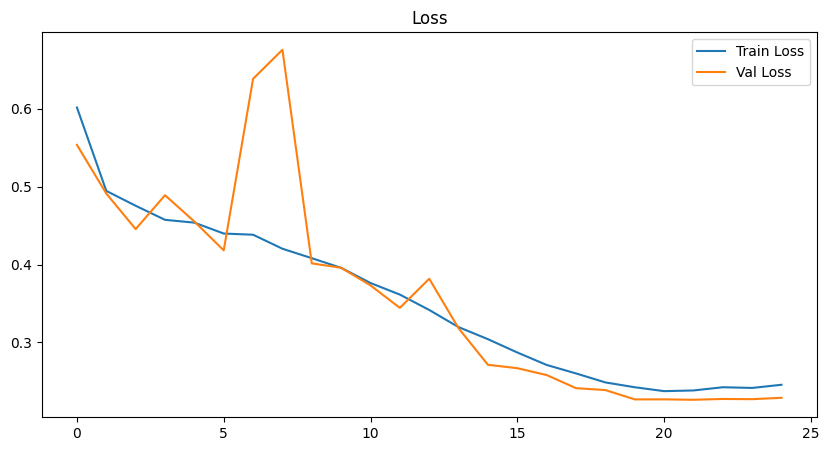

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.plot(test_train_losses_2, label="Train Loss")
ax.plot(test_validation_losses_2, label="Val Loss")
ax.legend()
ax.set_title("Loss")

In [41]:
def show_result(best_model_path, model):

  test_img_path = "/content/1728293261557.jpeg"
  test_img = Image.open(test_img_path)
  test_img = v2.ToImage()(test_img)
  base_transforms = v2.Compose([
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(dtype=torch.float32, scale=True)])
  # test_img = base_transforms(test_img) # Convert to float32
  # test_img = auto_transforms(test_img).unsqueeze(0).to(device)
  test_img = base_transforms(test_img).unsqueeze(0).to(device)



  model = model
  model.load_state_dict(torch.load(best_model_path, weights_only=True))
  model.eval()

  model.eval()
  with torch.inference_mode():
      y_logits = model(test_img)
      y_pred = torch.round(y_logits)
      # y_pred = torch.round(torch.sigmoid(y_logits))
      # preds = F.interpolate(y_pred, size=(224, 224), mode='bilinear', align_corners=False)

  pred_mask = y_pred.to("cpu").squeeze()

  plt.imshow(pred_mask)

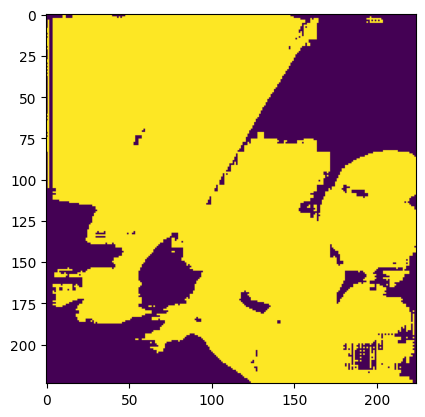

In [42]:
show_result(best_model_path="/content/my_best_checkpoint_sematic_segmentation_2.pth", model=model_1)